In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [7]:
# Load the training data
df = pd.read_csv("train_data_covid.csv")

In [8]:
# Replace '-' with 0
df.replace('-', 0, inplace=True)

In [9]:
# Handle missing values by filling with the value from the previous day
df.fillna(method='ffill', inplace=True)

In [10]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [11]:
# Extract 'Time' from 'Date'
df['Time'] = df['Date'].dt.time

In [12]:
# Extract day of the week from 'Date'
df['Day_of_Week'] = df['Date'].dt.weekday

In [13]:
# Calculate daily increase in confirmed cases
df['Daily_Increase_Confirmed'] = df['Confirmed'].diff()

In [14]:
# Create a LabelEncoder object
le = LabelEncoder()

In [15]:
# Combine the test and train data
test_df = pd.read_csv("test_data_covid.csv")
combine = pd.concat([df, test_df], axis=0)

In [16]:
# Fit the encoder
le.fit(combine["State/UnionTerritory"])

LabelEncoder()

In [17]:
# Encode the "State/UnionTerritory" column
df["State/UnionTerritory_Encoded"] = le.transform(df["State/UnionTerritory"])

In [18]:
# Select relevant features
features = ['Confirmed', 'Daily_Increase_Confirmed', 'PopulationDensityPerSqKm', "State/UnionTerritory_Encoded"]

In [19]:
# Feature scaling
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [20]:
# Define target variable
target = 'Deaths'

In [21]:
# Drop rows with NaN values resulting from diff() operation
df = df.dropna()

In [22]:
# Split data into input (X) and output (y) sequences
X = df[features].values
y = df[target].values

In [23]:
# Reshape input data for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])

In [24]:
# Split data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [25]:
# Add test data to the train data
X_train = np.concatenate((X_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)

In [26]:
# Define LSTM model architecture
model = Sequential([
    LSTM(units=1024, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(units=512, return_sequences=True),
    Dropout(0.3),
    LSTM(units=512, return_sequences=True),
    Dropout(0.3),
    LSTM(units=512),
    Dropout(0.3),
    Dense(units=256, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

In [27]:
# Compile model
model.compile(optimizer='adam', loss='mae')

In [28]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)

In [29]:
# Fit model
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.4, callbacks=[early_stopping], verbose=1)

Epoch 1/1000
71/71 [==============================] - 24s 57ms/step - loss: 1908.1533 - val_loss: 1224.2289
Epoch 2/1000
71/71 [==============================] - 1s 21ms/step - loss: 1057.8882 - val_loss: 1385.1775
Epoch 3/1000
71/71 [==============================] - 1s 19ms/step - loss: 940.7730 - val_loss: 742.5043
Epoch 4/1000
71/71 [==============================] - 1s 19ms/step - loss: 816.5192 - val_loss: 765.7781
Epoch 5/1000
71/71 [==============================] - 2s 25ms/step - loss: 794.9598 - val_loss: 713.5272
Epoch 6/1000
71/71 [==============================] - 2s 26ms/step - loss: 824.1202 - val_loss: 733.8793
Epoch 7/1000
71/71 [==============================] - 2s 23ms/step - loss: 803.8836 - val_loss: 719.0194
Epoch 8/1000
71/71 [==============================] - 2s 22ms/step - loss: 784.3528 - val_loss: 707.8967
Epoch 9/1000
71/71 [==============================] - 1s 21ms/step - loss: 777.6156 - val_loss: 680.1319
Epoch 10/1000
71/71 [=============================

In [30]:
# Evaluate model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

47/47 [==============================] - 0s 5ms/step - loss: 72.7729
Test Loss: 72.77285766601562


In [31]:
# Load test data
test_data = pd.read_csv("test_data_covid.csv")

In [32]:
# Handle missing values in test data
test_data.fillna(method='ffill', inplace=True)

In [35]:
# Convert 'Date' to datetime format
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%d-%m-%Y')

In [36]:
# Extract 'Time' from 'Date'
test_data['Time'] = test_data['Date'].dt.time

In [37]:
# Extract day of the week from 'Date'
test_data['Day_of_Week'] = test_data['Date'].dt.weekday

In [38]:
# Calculate daily increase in confirmed cases for test data
test_data['Daily_Increase_Confirmed'] = test_data['Confirmed'].diff()

In [39]:
# Encode categorical features for test data using the same LabelEncoder object
test_data["State/UnionTerritory_Encoded"] = le.transform(test_data["State/UnionTerritory"])

In [40]:
# Feature scaling for test data
test_data[features] = scaler.transform(test_data[features])

In [41]:
# Prepare test data for prediction
X_new = test_data[features].values
X_new = X_new.reshape(X_new.shape[0], 1, X_new.shape[1])

In [42]:
# Predict using the trained model
y_new = model.predict(X_new)
y_new = y_new.astype(int)

98/98 [==============================] - 2s 4ms/step


<ipython-input-42-fe8febaf1f2c>:3: RuntimeWarning: invalid value encountered in cast
  y_new = y_new.astype(int)


In [43]:
# Convert predictions to one-dimensional array
y_new = y_new.ravel()

In [44]:
# Save predictions to CSV with 'Sno' from test_data_covid.csv
output = pd.DataFrame({'Sno': test_data['Sno'], 'Deaths': y_new})

In [45]:
# Replace negative values with 0
output['Deaths'] = output['Deaths'].clip(lower=0)

In [46]:
# Display output
display(output)

,Sno,Deaths
0,15001,0
1,15002,86
2,15003,93
3,15004,2426
4,15005,1035
...,...,...
3105,18106,2986
3106,18107,759
3107,18108,4730
3108,18109,17079


In [47]:
# Save predictions to CSV file
output.to_csv('sample_submission.csv', index=False)

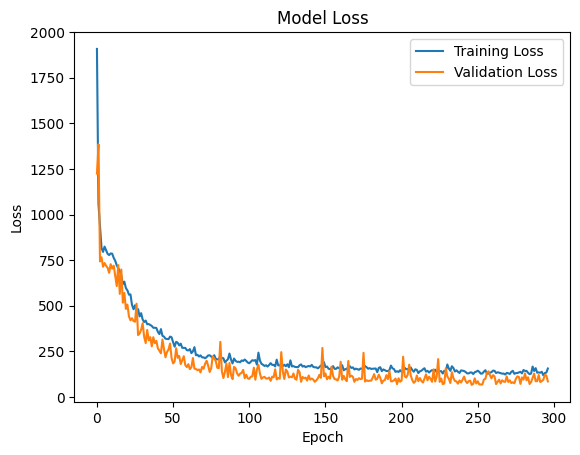

In [48]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()